# Compare gridded and microcat ds

- make sure they cover same time period
- select only points in gridded product where I have no NaNs in microcat data
- plot to compare

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator
import xarray as xr
import cmocean as cm
import marineHeatWaves as mhw
from datetime import date
import pickle

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [3]:
# gridded
file_name = "data/Rockall-Trough-Mooring-Time-Series-2020.nc"
ds = xr.open_dataset(file_name)

ds.coords['DEPTH'] = ds.PRES

ds = ds[['TG_EAST', 'TG_WEST']]

# for TG_EAST
ds['TG_EAST_C'] = ds.TG_EAST-273.15
ds.TG_EAST_C.attrs = ds.TG_EAST.attrs 
ds.TG_EAST_C.attrs['units'] = 'degC'
ds.TG_EAST_C.attrs

# and TG_WEST
ds['TG_WEST_C'] = ds.TG_WEST-273.15
ds.TG_WEST_C.attrs = ds.TG_WEST.attrs 
ds.TG_WEST_C.attrs['units'] = 'degC'
ds.TG_WEST_C.attrs;

ds1D = ds.resample(TIME = "1D").mean(keep_attrs=True);

## split it up into east and west dataset

ds_ebg = ds1D[['TG_EAST_C']]
ds_wbg = ds1D[['TG_WEST_C']]

In [4]:
# microcat
file_name = "data/rteb_all_1D.nc"
ds_eb = xr.open_dataset(file_name)
ds_eb = ds_eb.rename({'depth':'DEPTH','time':'TIME'})

file_name = "data/rtwb_1D.nc"
ds_wb = xr.open_dataset(file_name)
ds_wb = ds_wb.rename({'depth':'DEPTH','time':'TIME'})

In [5]:
# overwriting depths for ds_eb, 1760 seems to be to deep
ds_eb['DEPTH'] = [  50.,   75.,  100.,  250.,  500.,  750.,  950., 1000., 1250., 1500., 1600., 1750.]


In [6]:
ds_eb

<xarray.Dataset>
Dimensions:  (DEPTH: 12, TIME: 2279)
Coordinates:
  * DEPTH    (DEPTH) float64 50.0 75.0 100.0 250.0 ... 1.5e+03 1.6e+03 1.75e+03
  * TIME     (TIME) datetime64[ns] 2014-07-18 2014-07-19 ... 2020-10-12
Data variables:
    oxy      (TIME, DEPTH) float64 ...
    temp     (TIME, DEPTH) float64 ...
    pres     (TIME, DEPTH) float64 ...
    sal      (TIME, DEPTH) float64 ...
Attributes:
    Mooring:          rteb1
    WaterDepth:       1800
    Start_Date:       2014/07/18
    Start_Time:       12:30
    End_Date:         2015/06/20
    End_Time:         06:30
    Latitude:         57.099333333333334
    Longitude:        -9.548
    Latitude_units:   degrees_north
    Longitude_units:  degrees_east

In [7]:
depth_EB = np.array(ds_eb.DEPTH).astype(int)
depth_WB = np.array(ds_wb.DEPTH).astype(int)

# Mask

hey Kristin... as I understood it I should create a mask that selects the data from the gridded product that is closest to the mooring depths and only selects data at the points where I have data in my microcat data... is that right?

I am trying to do this but I am not really sure how it is supposed to work ... What I am doing is not really creating a boolean array that I can then use with the gridded product.

In [8]:
# First we need to make sure that the datasets have the same dimensions
ds_ebg = ds_ebg.sel(TIME=ds_eb.TIME, DEPTH=ds_eb.DEPTH,method='nearest')
ds_ebg.coords['DEPTH']=ds_eb.DEPTH
ds_wbg = ds_wbg.sel(TIME=ds_wb.TIME, DEPTH=ds_wb.DEPTH,method='nearest')
ds_wbg.coords['DEPTH']=ds_wb.DEPTH
display(ds_ebg.sizes,ds_eb.sizes)
display(ds_wbg.sizes,ds_wb.sizes);

Frozen(SortedKeysDict({'TIME': 2279, 'DEPTH': 12}))

Frozen(SortedKeysDict({'TIME': 2279, 'DEPTH': 12}))

Frozen(SortedKeysDict({'TIME': 2282, 'DEPTH': 11}))

Frozen(SortedKeysDict({'DEPTH': 11, 'TIME': 2282}))

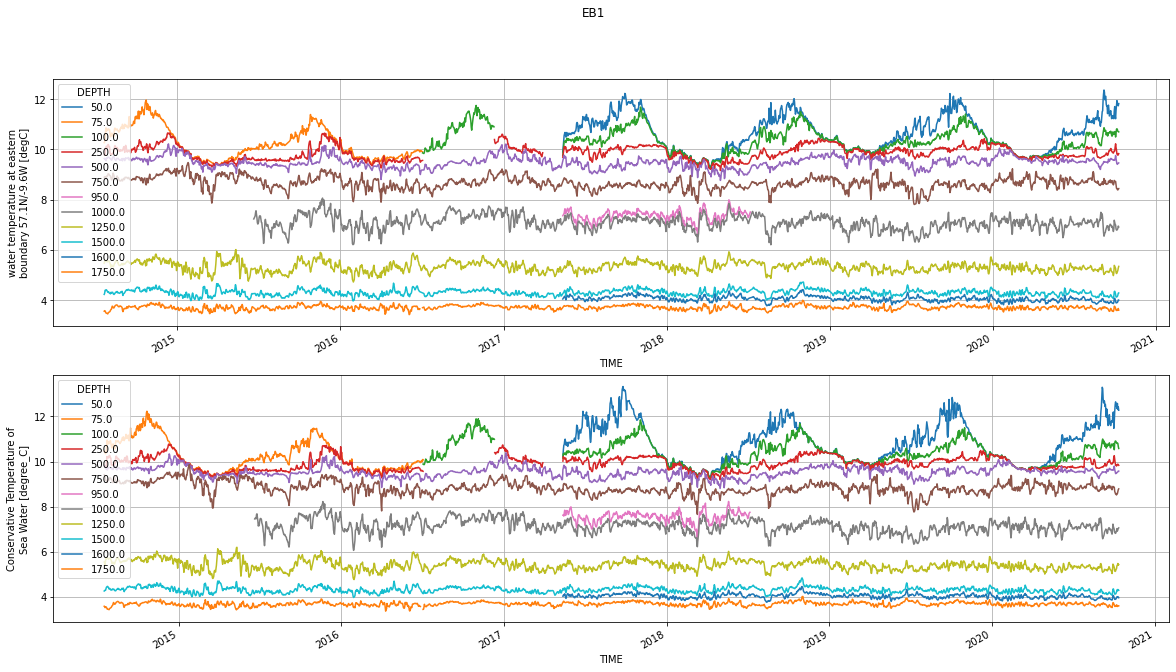

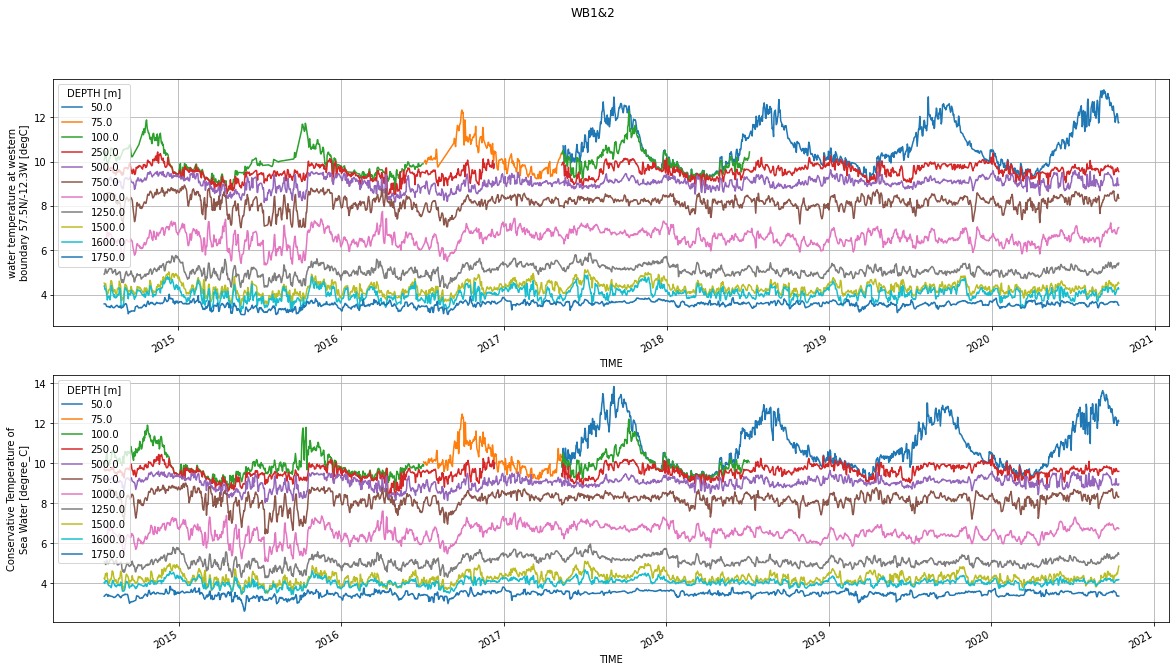

In [9]:
# no we set all values in the gridded product nan where we find nan in the ungrided product
ds_ebg = ds_ebg.where(ds_eb.temp.notnull())
ds_wbg = ds_wbg.where(ds_wb.temp.notnull())

# and plot the results to control
fig,axs = plt.subplots(2,1,figsize=[20,10])
ds_ebg.TG_EAST_C.plot.line(x='TIME',ax=axs[0])
ds_eb.temp.plot.line(x='TIME',ax=axs[1])
fig.suptitle('EB1')

for ax in axs:
    ax.grid()

fig,axs = plt.subplots(2,1,figsize=[20,10])
ds_wbg.TG_WEST_C.plot.line(x='TIME',ax=axs[0])
ds_wb.temp.plot.line(x='TIME',ax=axs[1])
fig.suptitle('WB1&2')

for ax in axs:
    ax.grid()

Apparently the gridded product does not have 1755m for EB1. Maybe the pressure was always lower. As an alternative we could overwrite the depth array of ds_eb with a shallower deepest depth as the beginning of cell `[6]`: `ds_eb.DEPTH = [  50.,   75.,  100.,  250.,  500.,  750.,  950., 1000., 1250., 1500., 1600., 1770.]`

In [10]:
ds_eb.DEPTH.values

array([  50.,   75.,  100.,  250.,  500.,  750.,  950., 1000., 1250.,
       1500., 1600., 1750.])

# Functions

In [11]:
def MHW_func (data, depth, climP=[2014.0,2020.0], altClim=False):
    yy_start = int(data.TIME[0].dt.year)
    yy_end = int(data.TIME[-1].dt.year)
    mm_start = int(data.TIME[0].dt.month)
    mm_end = int(data.TIME[-1].dt.month)
    dd_start = int(data.TIME[0].dt.day)
    dd_end = int(data.TIME[-1].dt.day)
    
    t = np.arange(
        date(yy_start, mm_start, dd_start).toordinal(),                 # .toordinal turns the date into a number that the algorithm can process
        date(yy_end, mm_end, dd_end).toordinal()+1,1) 
    
    temp = data.sel(DEPTH=depth, method = 'nearest').squeeze().values   # by using .squeeze().values we are first removing any other depth and then turning the data into a 1d numpy array 
                                                                        # without doing this the data will still be in an array and the algorithm can't handle it
    
    mhws, clim = mhw.detect(t, temp, climatologyPeriod=climP, alternateClimatology=altClim)                                    # using the algorithm
    mcss, clim_cold = mhw.detect(t, temp, coldSpells = True, climatologyPeriod=climP, alternateClimatology=altClim)            # cold spells 
    return mhws, mcss, clim, clim_cold, t, temp  

In [12]:
def DICT_func(data, depth): 
    mhws_,mcss_,clim_,clim_cold_,t_,temp_ = {},{},{},{},{},{}
    
    for n in depth:
        mhws, mcss, clim, clim_cold, t, temp = MHW_func(data, n) 
        mhws_.update({str(n):mhws})
        mcss_.update({str(n):mcss})
        clim_.update({str(n):clim})
        clim_cold_.update({str(n):clim_cold})
        t_.update({str(n):t})
        temp_.update({str(n):temp})
    
    dictionary = {'mhws':mhws_,'mcss':mcss_,'clim':clim_,'clim_cold':clim_cold_,'t':t_,'temp':temp_}
    return dictionary

In [13]:
def OV_stacked_events(dict, n):
    
    #defining my variables
    mhws = dict['mhws'][str(n)]
    mcss = dict['mcss'][str(n)]
    t = dict['t'][str(n)]
    temp = dict['temp'][str(n)]
    clim = dict['clim'][str(n)]
    clim_cold = dict['clim_cold'][str(n)]
    
    dates = [date.fromordinal(tt.astype(int)) for tt in t]
        
    ev = (mhws['n_events'])
    ec = (mcss['n_events'])

    fig, ax = plt.subplots(figsize=(30,3),frameon=False)
    plt.subplot(1,1,1)

    # Find all MHWs and shade
    for ev0 in np.arange (ev):
        t1 = np.where(t==mhws['time_start'][ev0])[0][0]
        t2 = np.where(t==mhws['time_end'][ev0])[0][0]
        plt.axvspan(xmin=dates[t1], xmax=dates[t2],color='deeppink')

    # same for cold spells
    for ec0 in np.arange(ec):
        tc1 = np.where(t==mcss['time_start'][ec0])[0][0]
        tc2 = np.where(t==mcss['time_end'][ec0])[0][0]
        plt.axvspan(xmin=dates[tc1], xmax=dates[tc2],color='darkcyan')
        
    # Plot t, seasonal cycle, threshold, shade MHWs with main event in red
    plt.plot(dates, clim['thresh'], ':r', linewidth=0.1, label = 'Threshold warm')
    plt.plot(dates, clim_cold['thresh'], ':g', linewidth=0.1, label = 'Threshold cold')
    plt.plot(dates, temp, 'k', linewidth=.1, label = 'Temperature')
    plt.plot(dates, clim['seas'], 'b', linewidth=.1, label = 'Climatology')
    
    if n == 50.0:
        plt.title('Marine Heatwaves and Cold Spells')
    
    plt.xlim(date(2014,7,15), date(2020,10,20))
    plt.grid()
    plt.ylabel(str(n));

# Create Dictionaries

In [14]:
EB_grid = DICT_func(ds_ebg.TG_EAST_C, depth_EB)
WB_grid = DICT_func(ds_wbg.TG_WEST_C, depth_WB)

EB_mcat = DICT_func(ds_eb.temp, depth_EB)
WB_mcat = DICT_func(ds_wb.temp, depth_WB)

## Fix clim ????
for gridded data at EB, 2017 knock-down event...

actually i don't think I need this since I corrected for this in the db_eb ds and i am only taking values out of the db_ebg ds that exist in the ds_eb dataset... I hope that makes sense...

In [15]:
# temp_100_orig = EB_grid['temp']['100']
# clim_100_orig = EB_grid['clim']['100']
# dsNC = xr.concat([ds_ebg.sel(TIME = slice('2014-6-1', '2016-5-31')), ds_ebg.sel(TIME = slice('2017-6-1', '2020-5-31'))],dim='TIME')

# # alternative timeline
# t_alt = np.concatenate((np.arange(
#         date(2014,6,1).toordinal(),
#         date(2016,5,31).toordinal()+1,1), 
#         np.arange(
#         date(2017,6,1).toordinal(),
#         date(2020,5,31).toordinal()+1,1)))

# # alternative temperature
# temp_alt = dsNC.TG_EAST_C.sel(DEPTH=100).squeeze().values 
# temp_100 = ds_ebg.TG_EAST_C.sel(DEPTH=100)
# temp_100 = temp_100.where((temp_100.TIME<np.datetime64('2016-12-10')) | (temp_100.TIME>np.datetime64('2017-05-17'))).squeeze().values

# EB_grid['temp']['100'] = temp_100
# t_100 = EB_grid['t']['100']

# mhws_alt, clim_alt = mhw.detect(t_100, temp_100, climatologyPeriod= [2014.0, 2020.0], alternateClimatology=[t_alt,temp_alt])
# EB_grid['mhws']['100'] = mhws_alt
# EB_grid['clim']['100'] = clim_alt

# mcss_alt, clim_cold_alt = mhw.detect(t_100,temp_100, climatologyPeriod= [2014.0, 2020.0], alternateClimatology=[t_alt,temp_alt], coldSpells=True)
# EB_grid['mcss']['100'] = mcss_alt
# EB_grid['clim_cold']['100'] = clim_cold_alt

# Compare
### **Eastern Boundary**

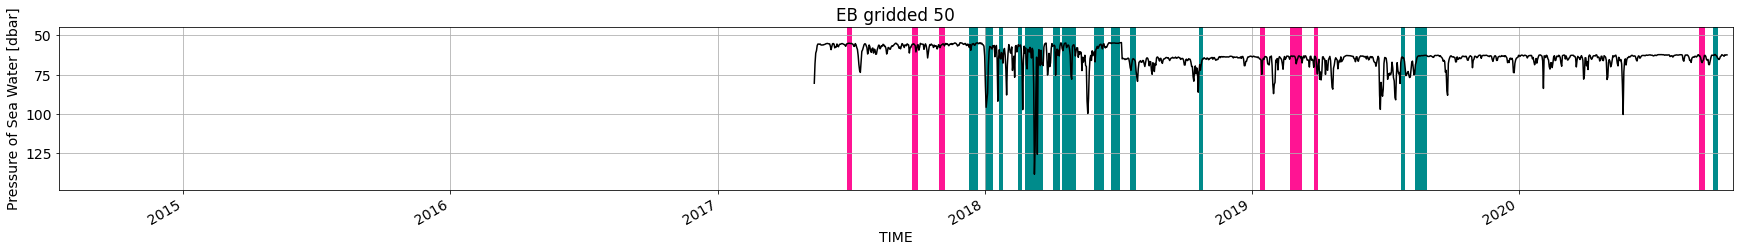

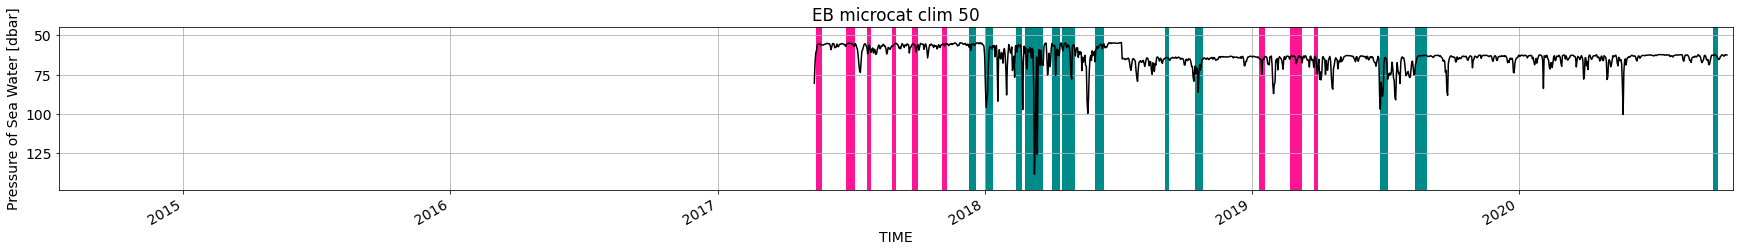

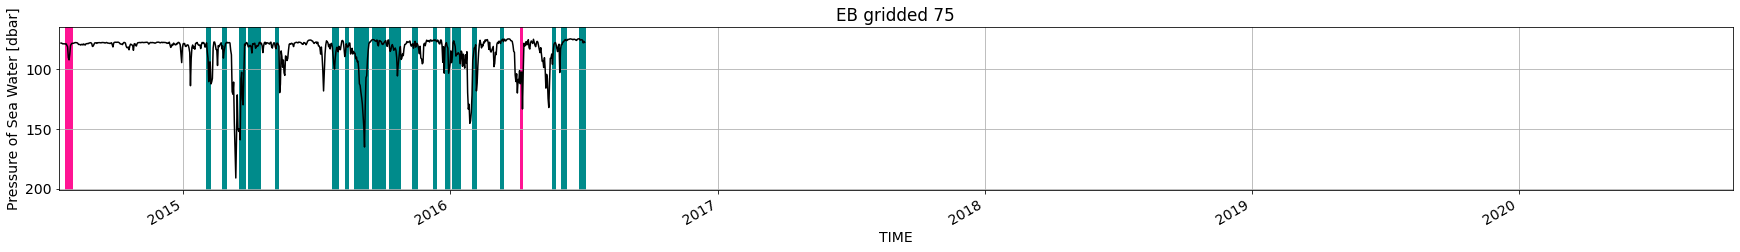

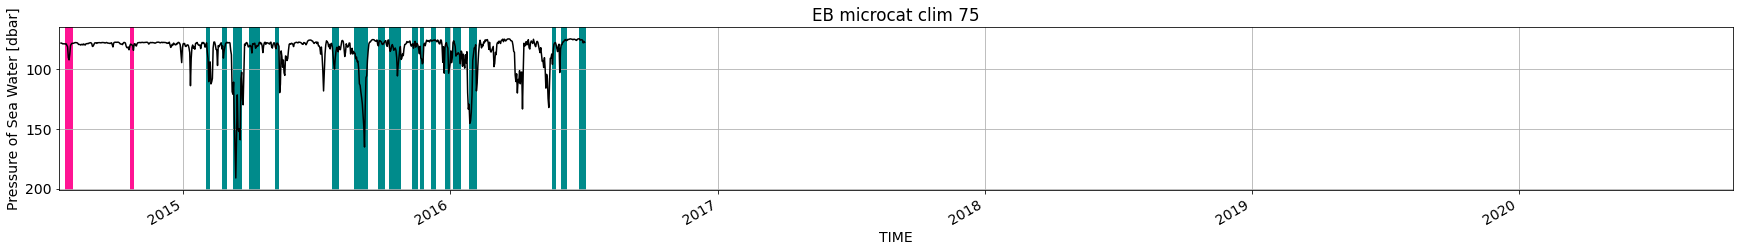

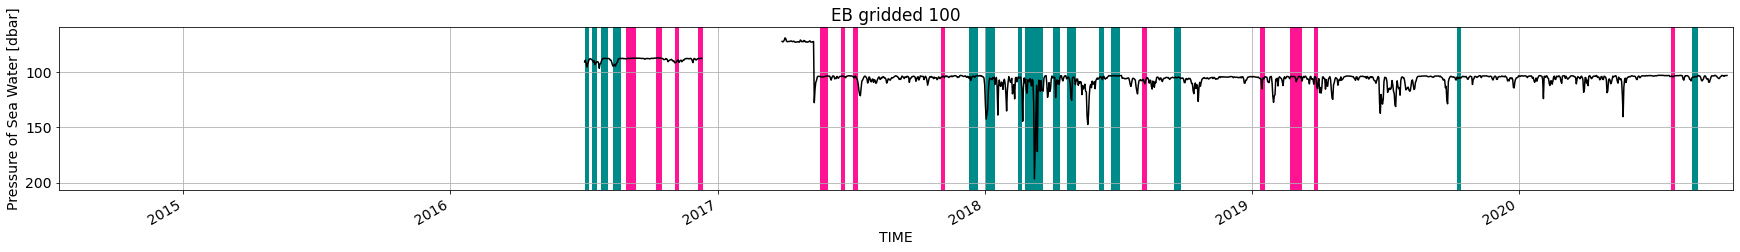

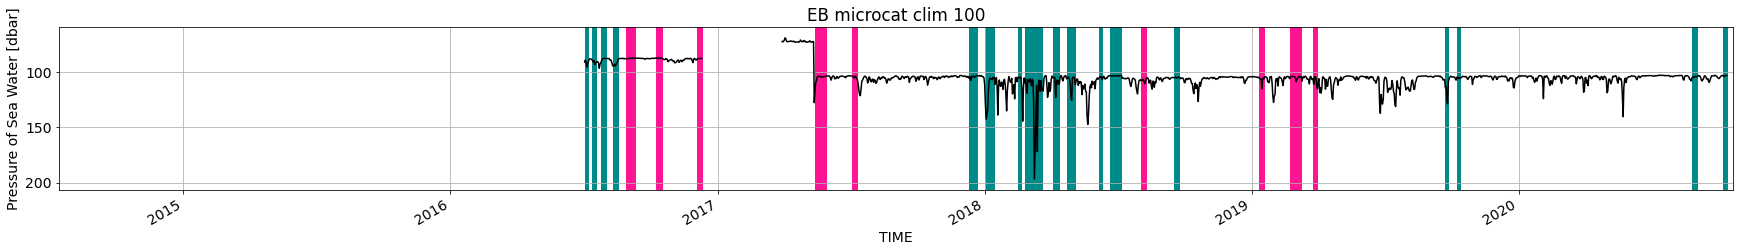

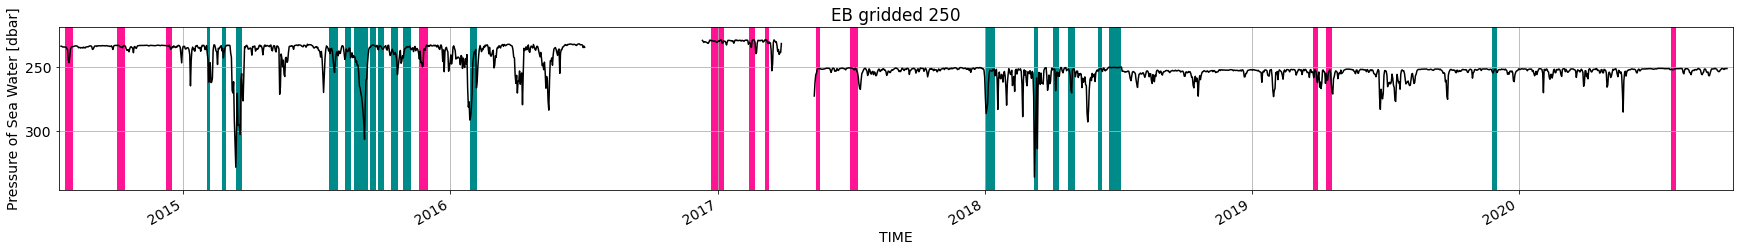

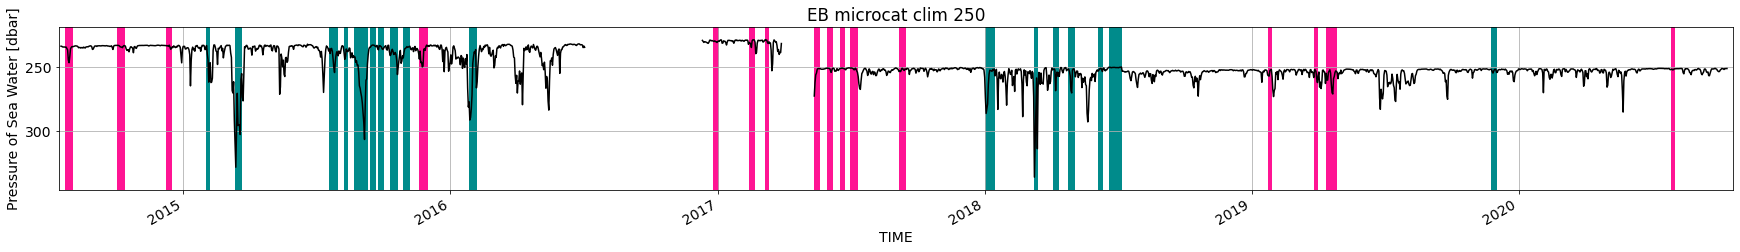

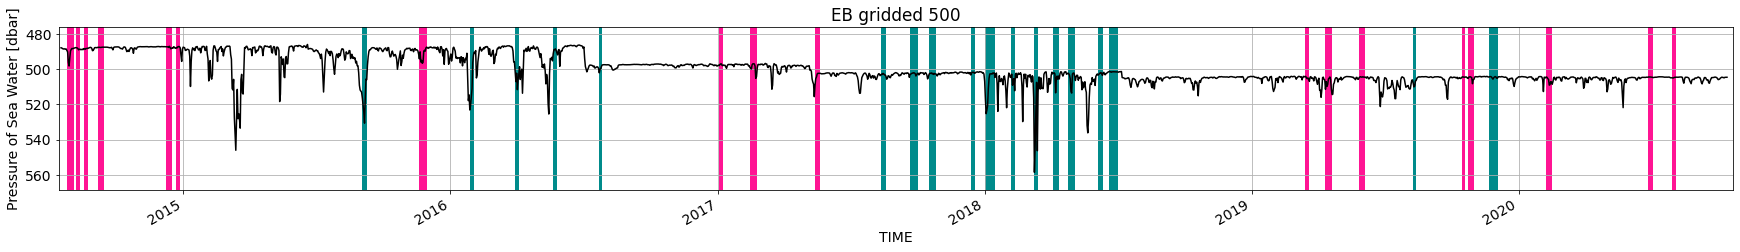

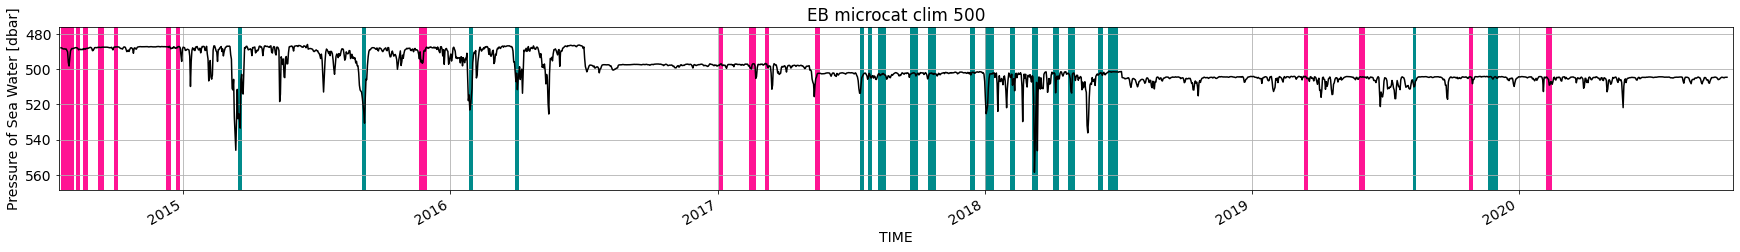

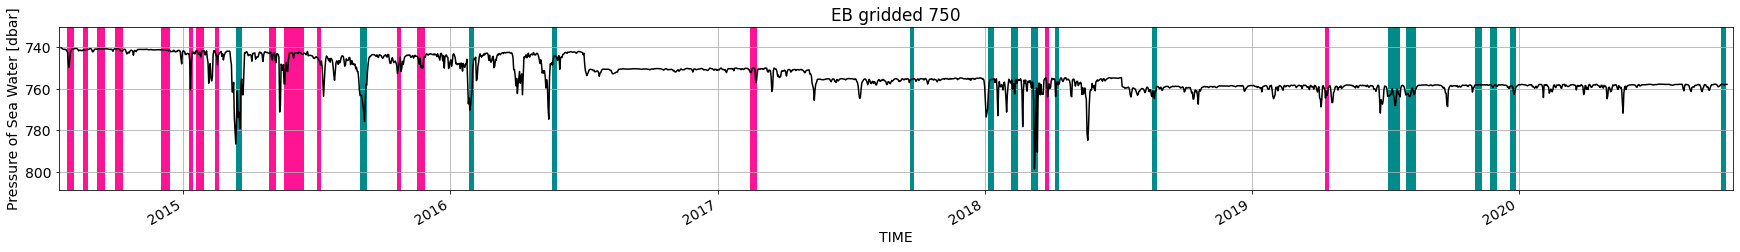

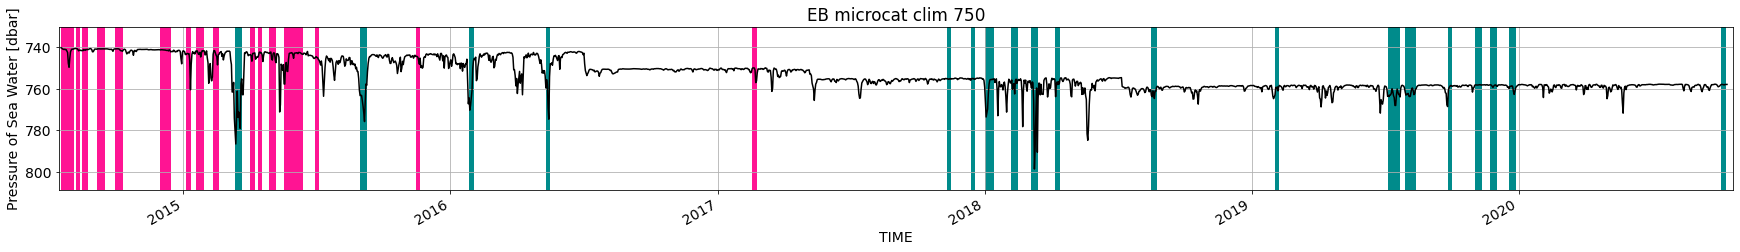

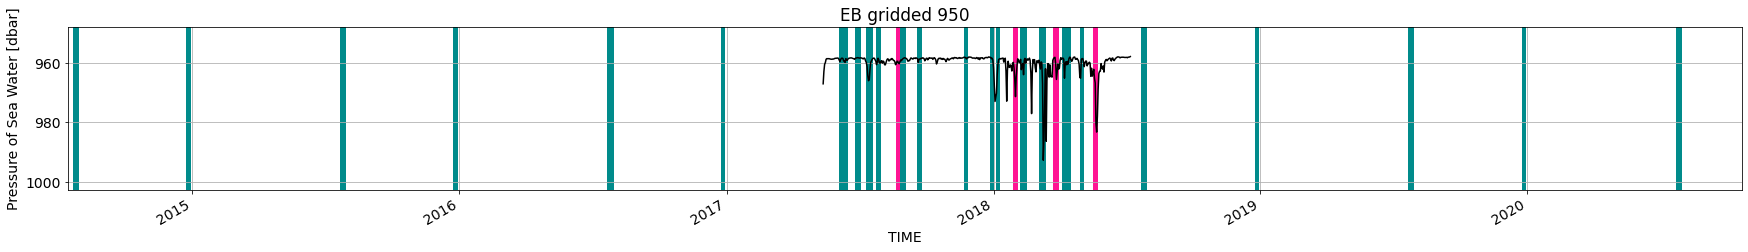

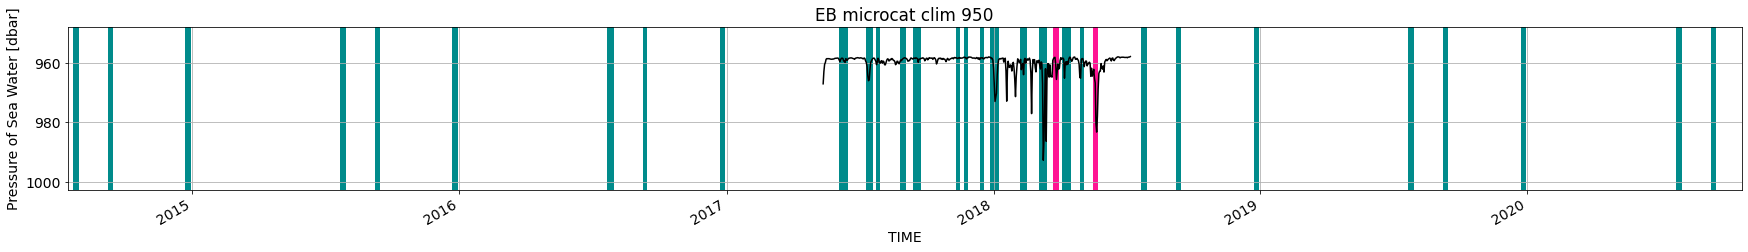

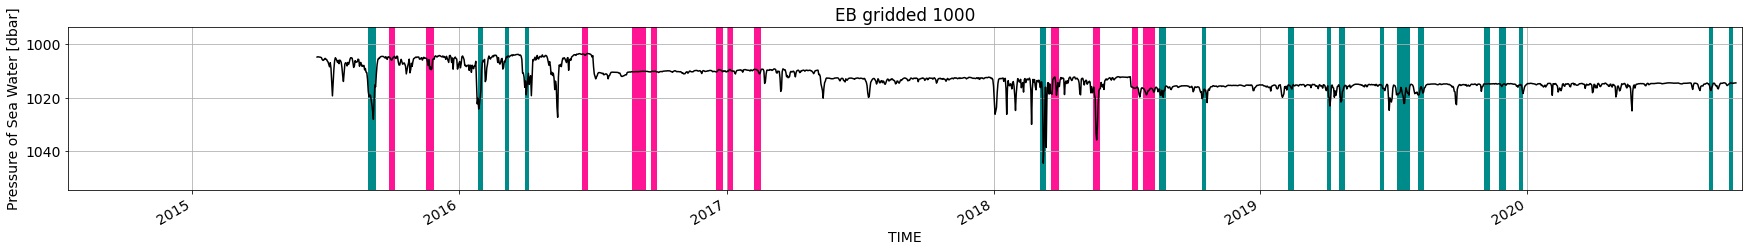

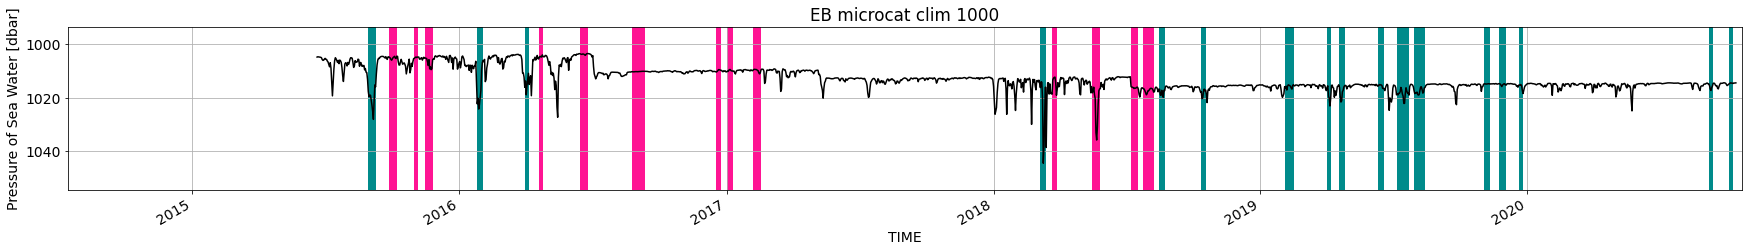

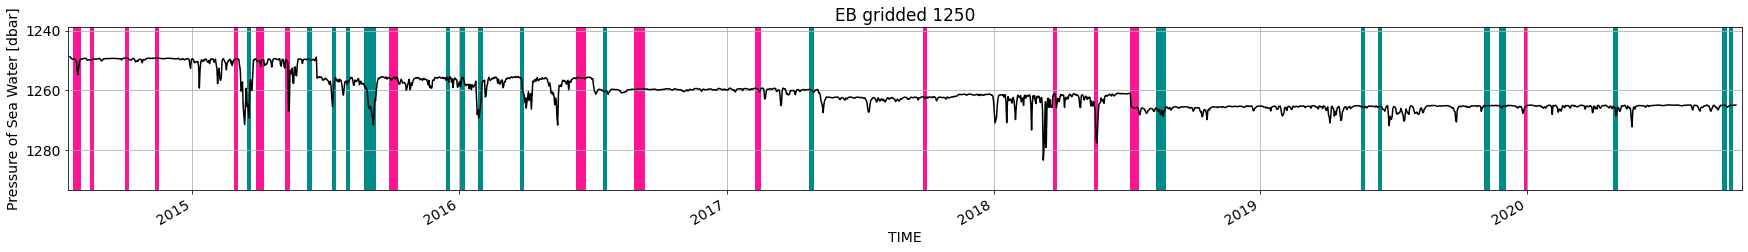

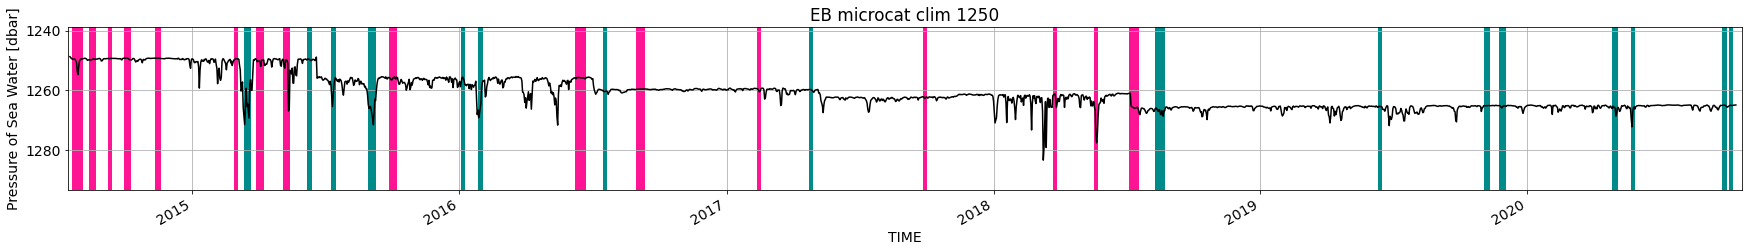

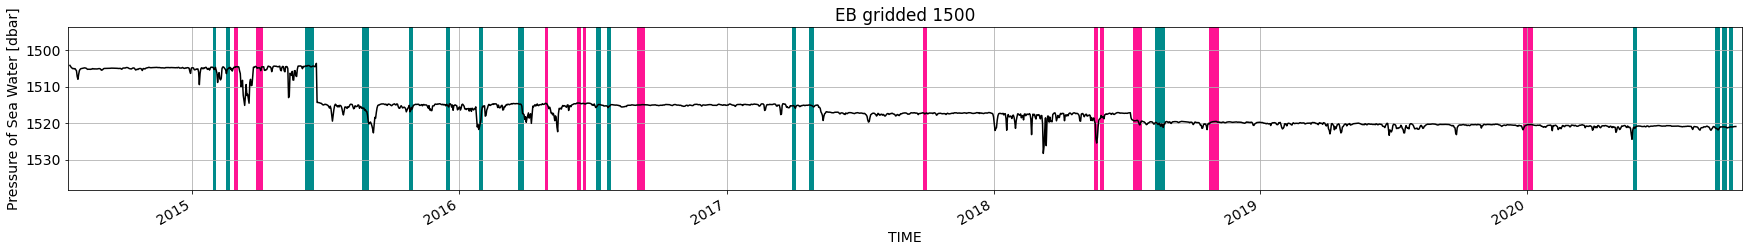

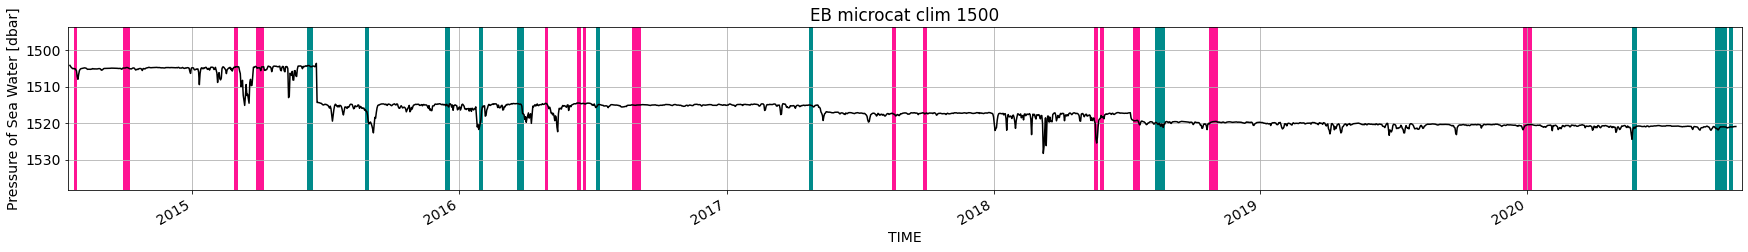

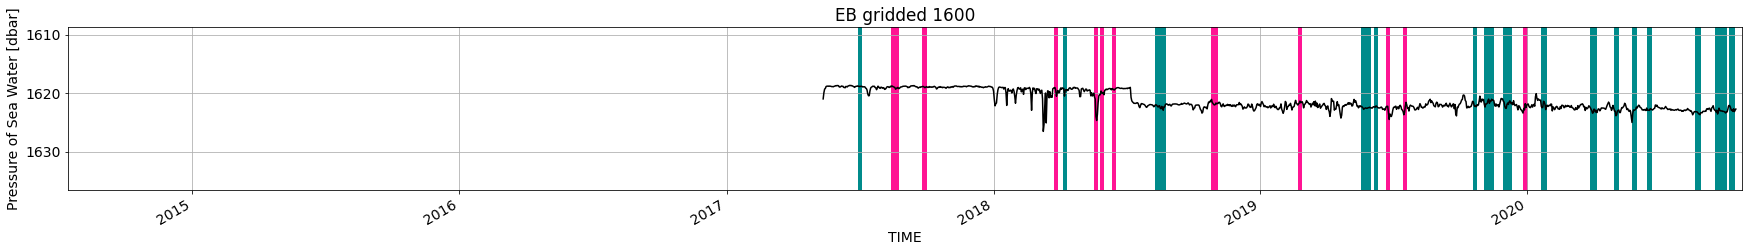

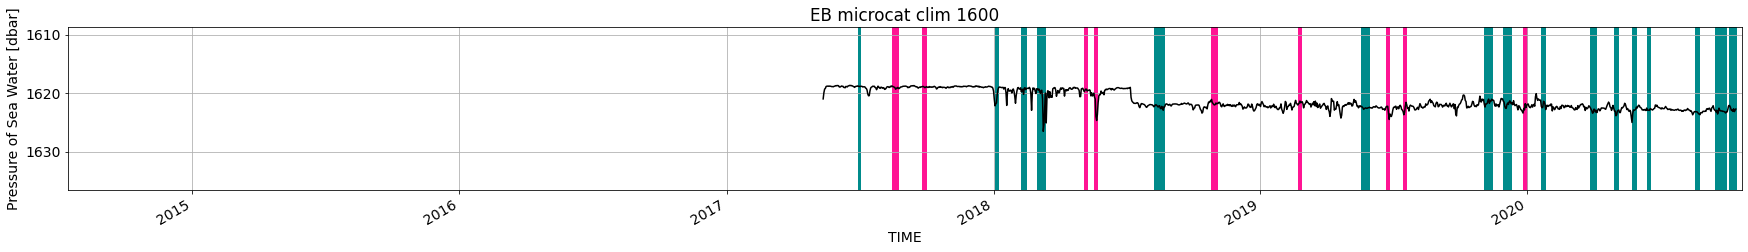

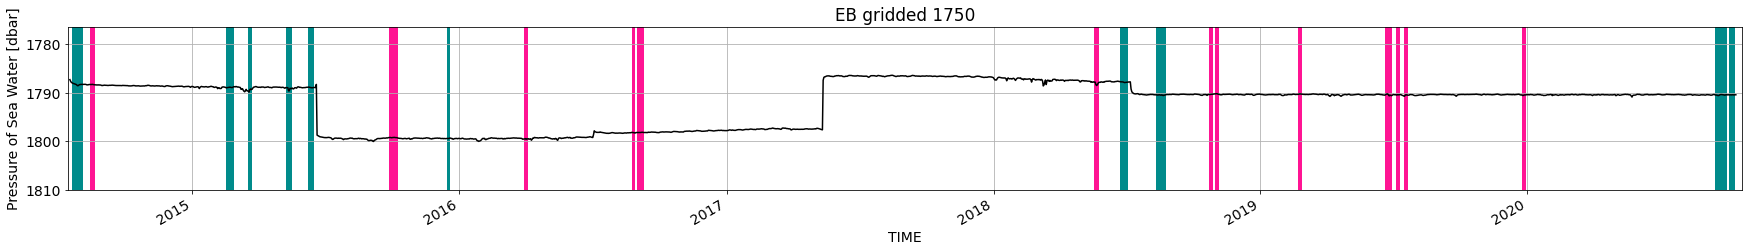

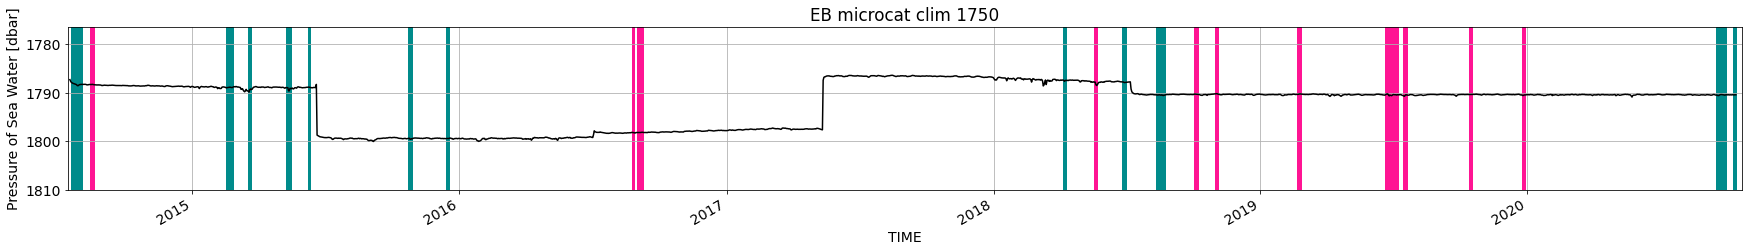

In [18]:
for i,n in enumerate(depth_EB):
    
    font = {'weight' : 'normal','size' : 14}
    plt.rc('font', **font)
    
    OV_stacked_events(EB_grid, n)
    ds_eb.pres.sel(DEPTH=n).plot.line(x='TIME', color='k')
    plt.ylim(ds_eb.pres.sel(DEPTH=n).max()+10, ds_eb.pres.sel(DEPTH=n).min()-10)
    plt.title(f'EB gridded {n}')
    ax = plt.axes() 
    #ax.set_facecolor("#F0FFFF") 
    #plt.savefig(f'figures/Compare_EB/EB_{n}_grid', dpi = 300)
    
    OV_stacked_events(EB_mcat, n)
    ds_eb.pres.sel(DEPTH=n).plot.line(x='TIME', color='k')
    plt.ylim(ds_eb.pres.sel(DEPTH=n).max()+10, ds_eb.pres.sel(DEPTH=n).min()-10)
    plt.title(f'EB microcat clim {n}')
    
    #plt.savefig(f'figures/Compare_EB/EB_{n}_mcat', dpi = 300)

### **Western Boundary**

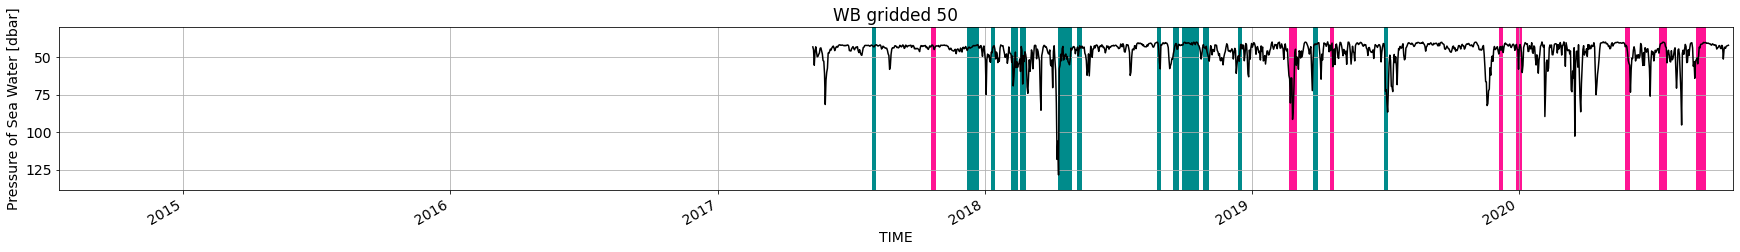

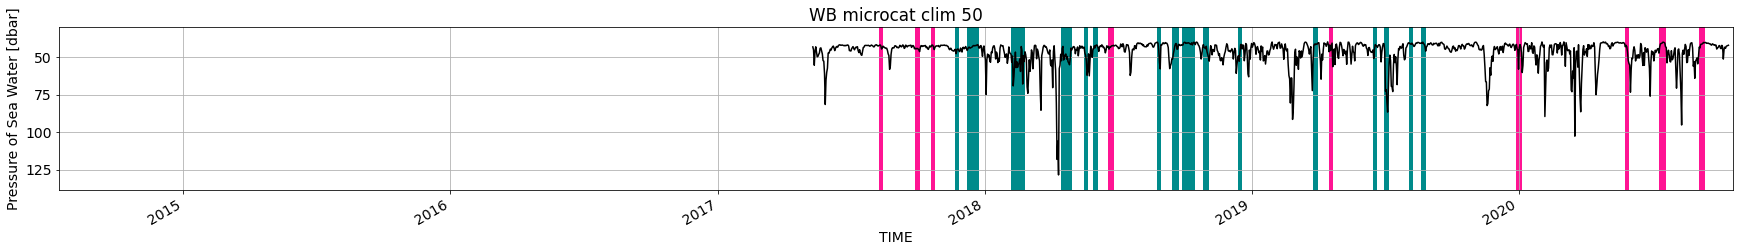

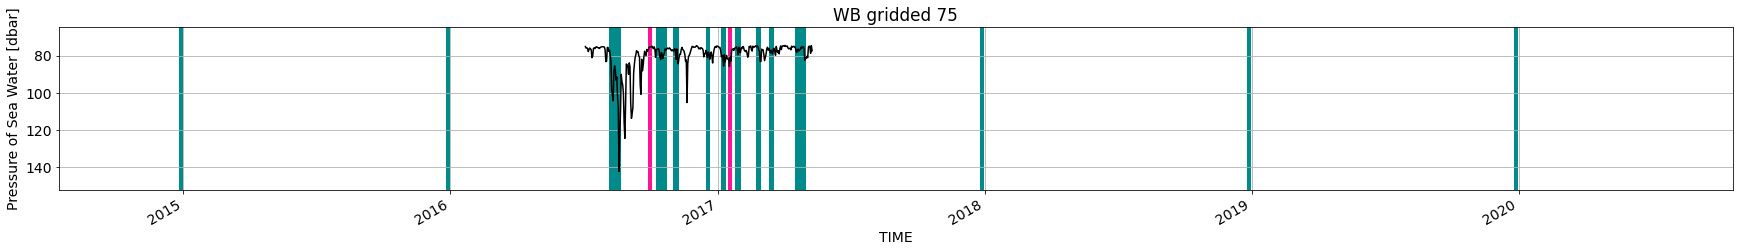

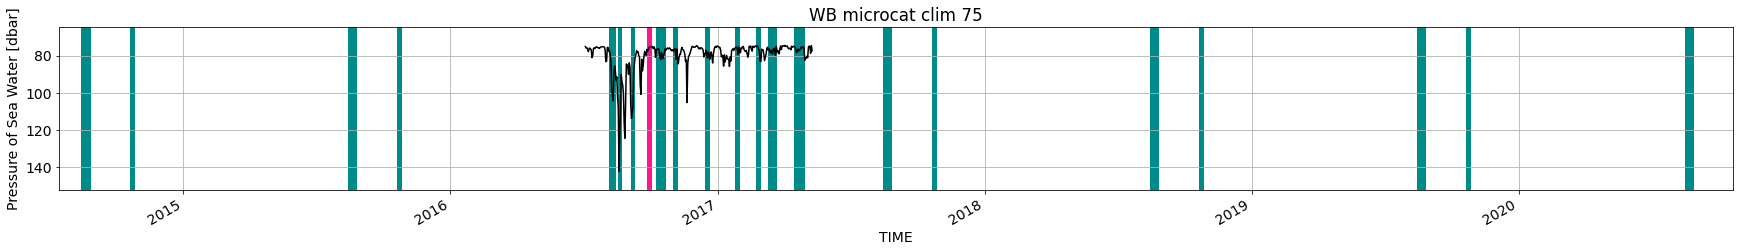

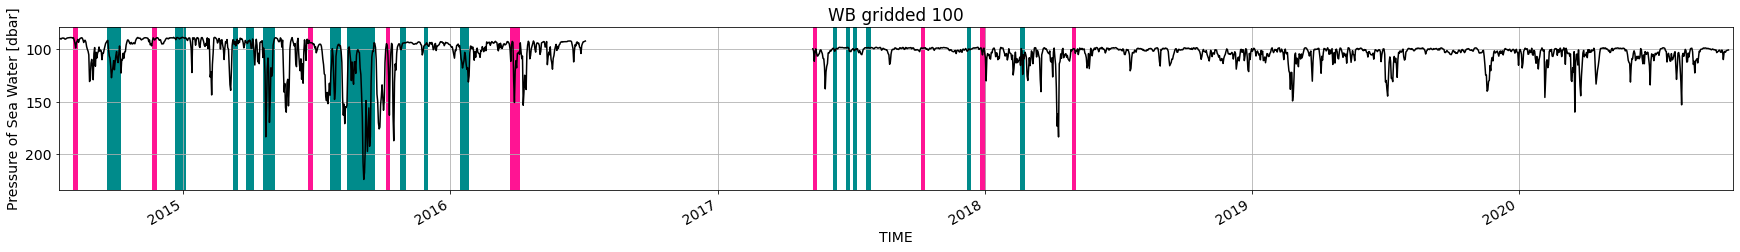

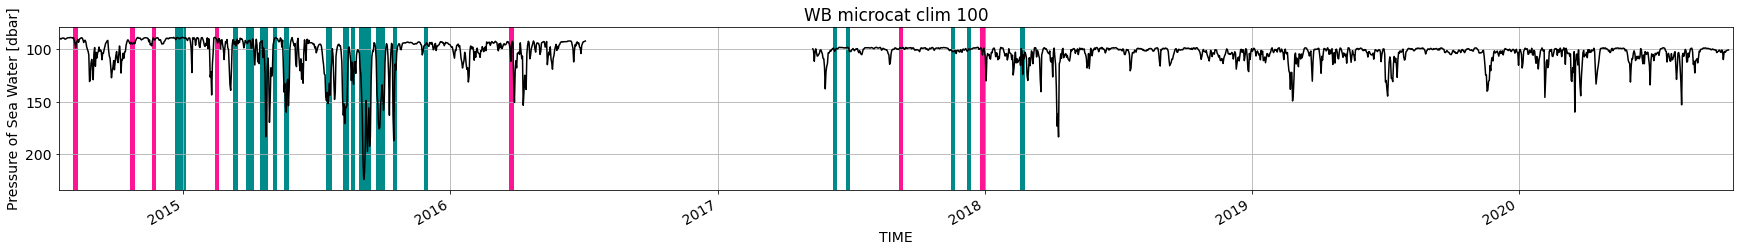

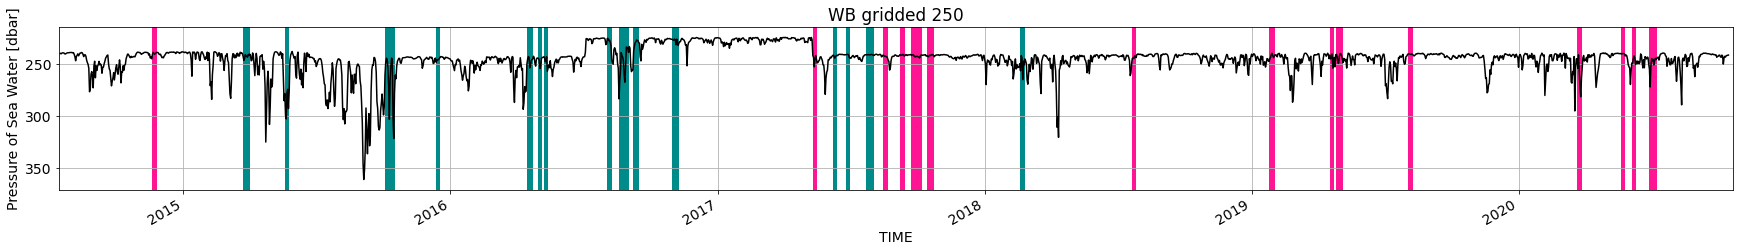

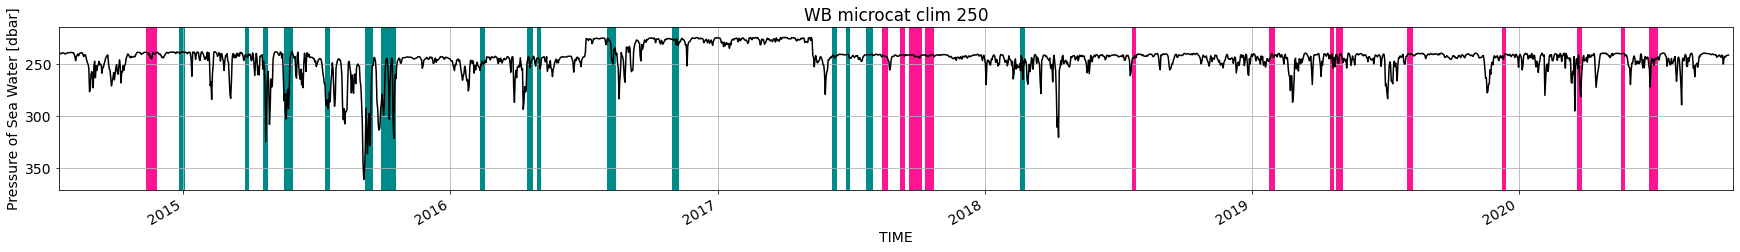

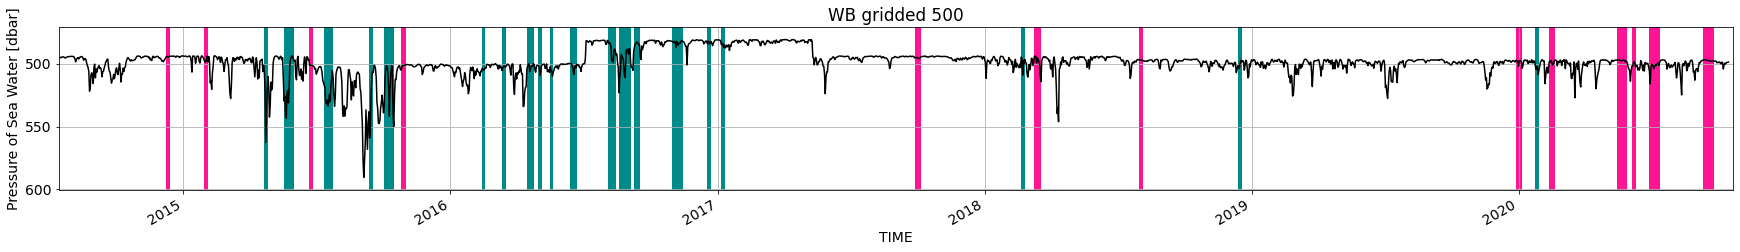

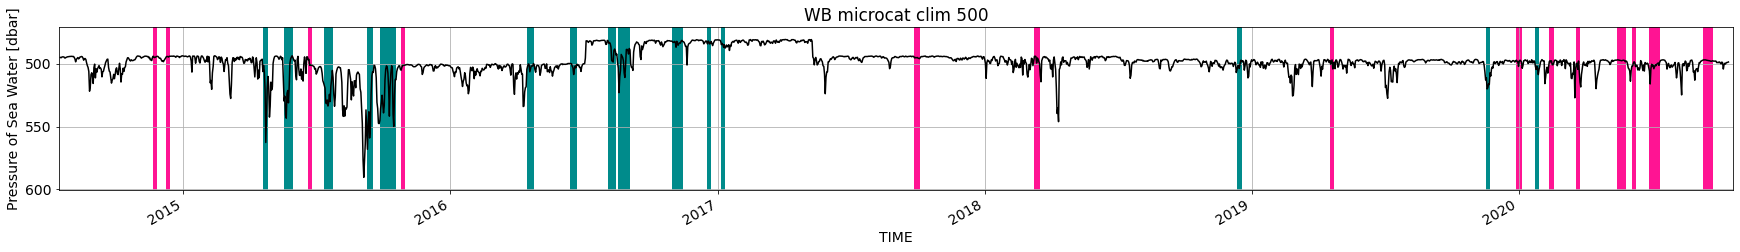

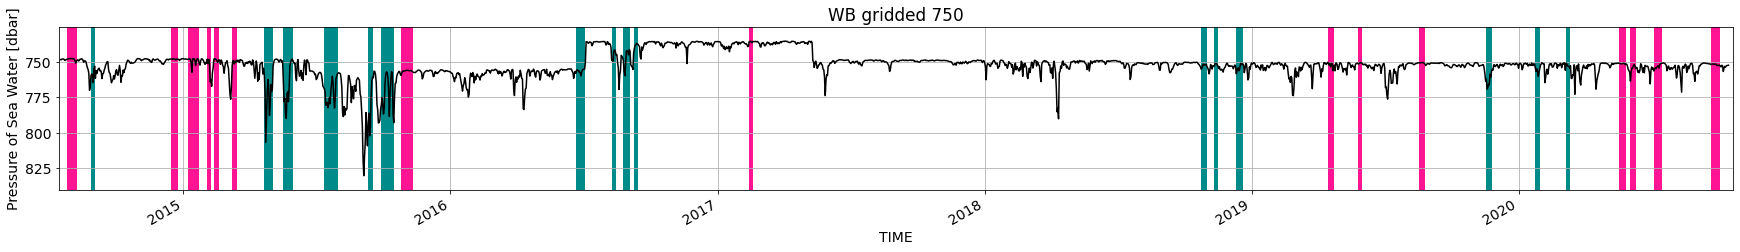

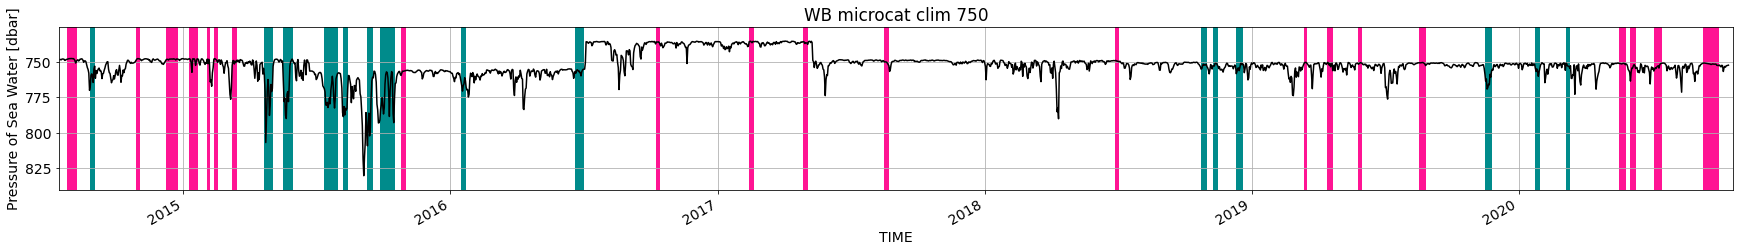

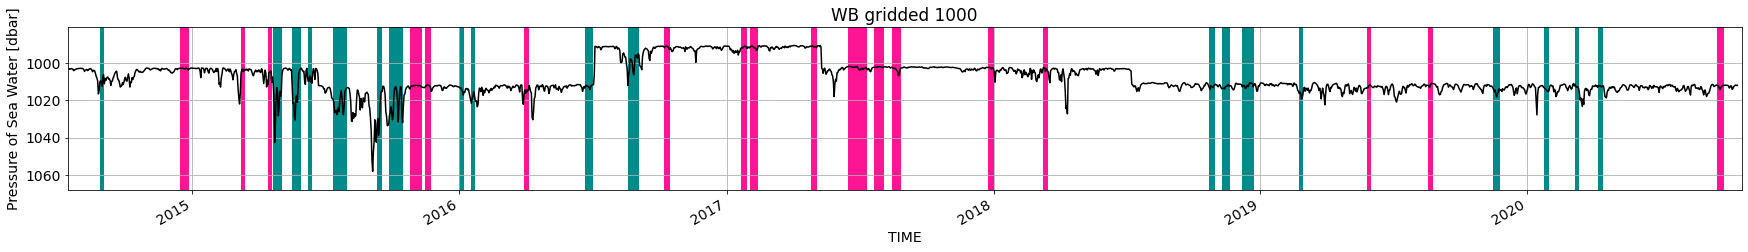

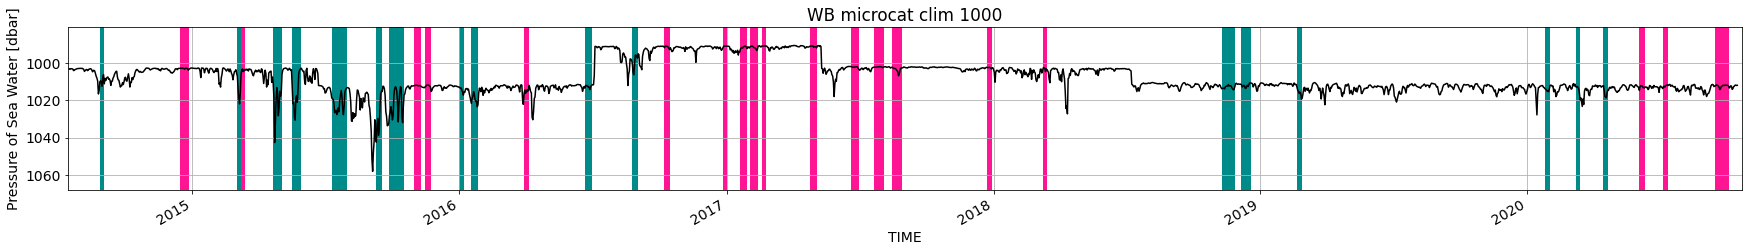

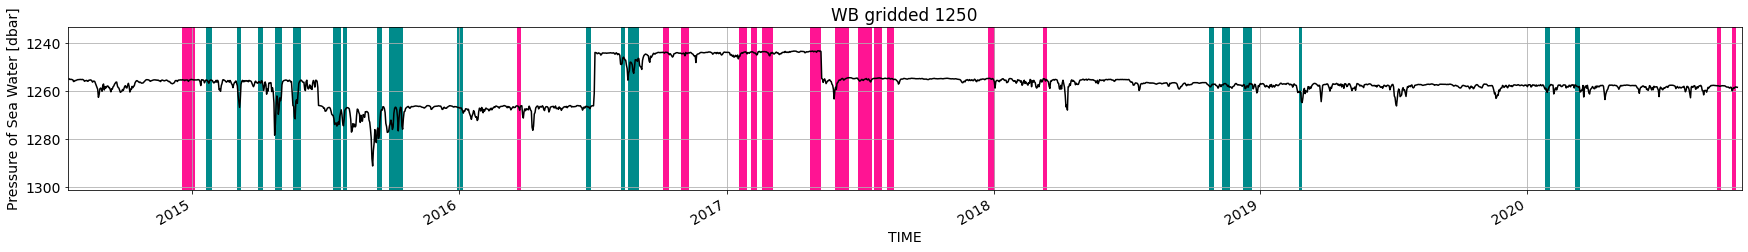

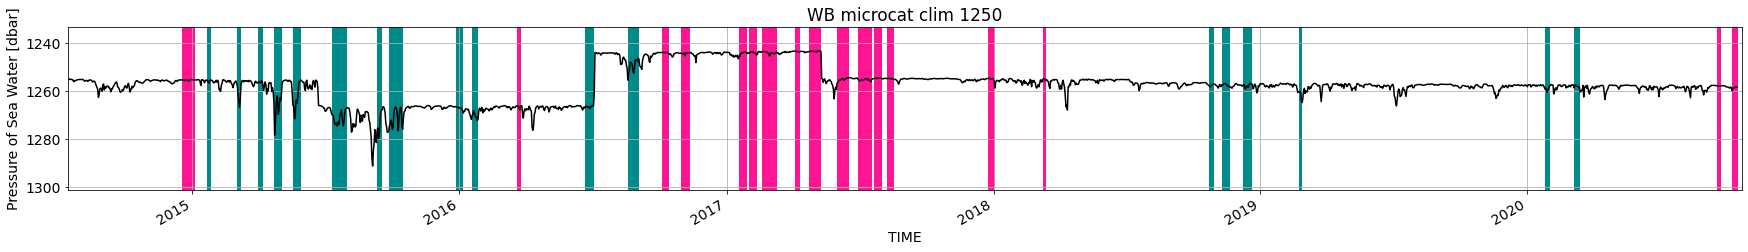

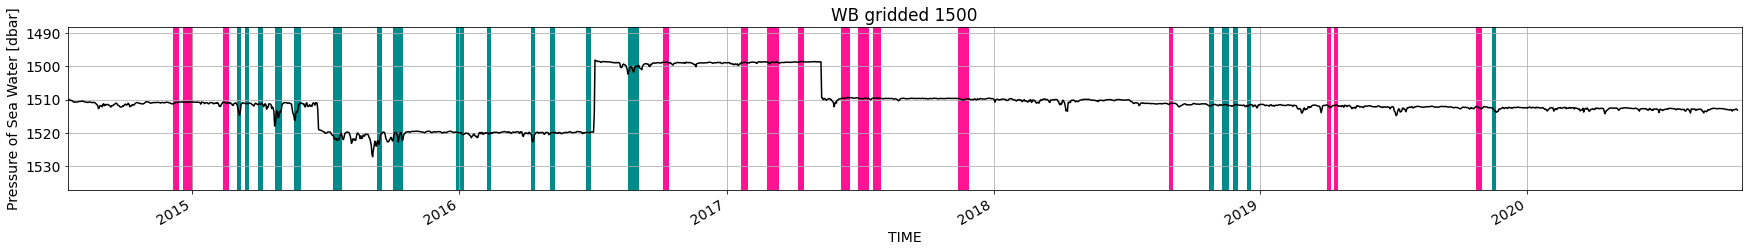

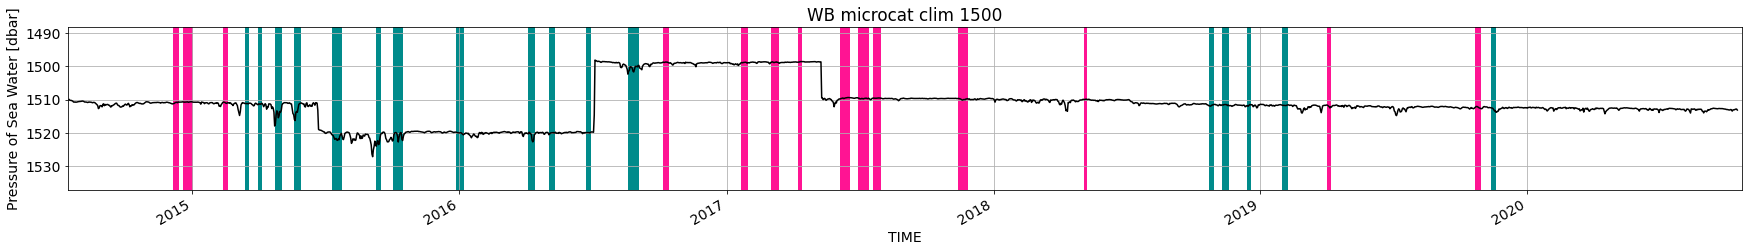

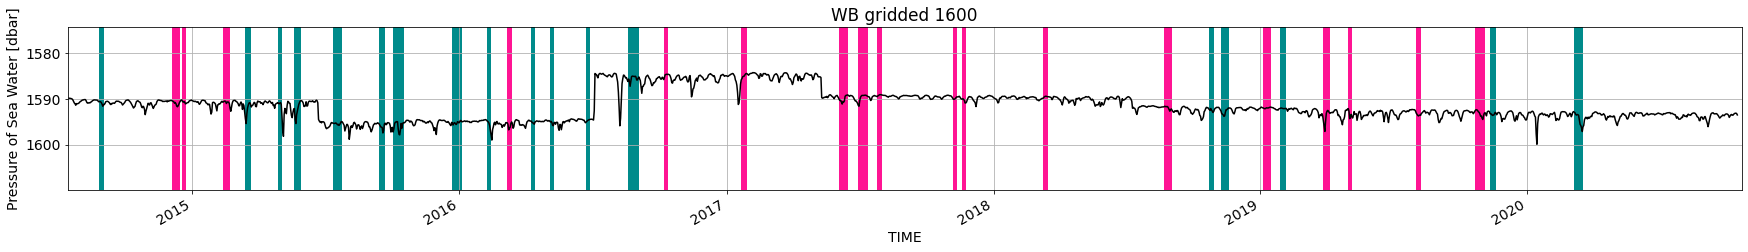

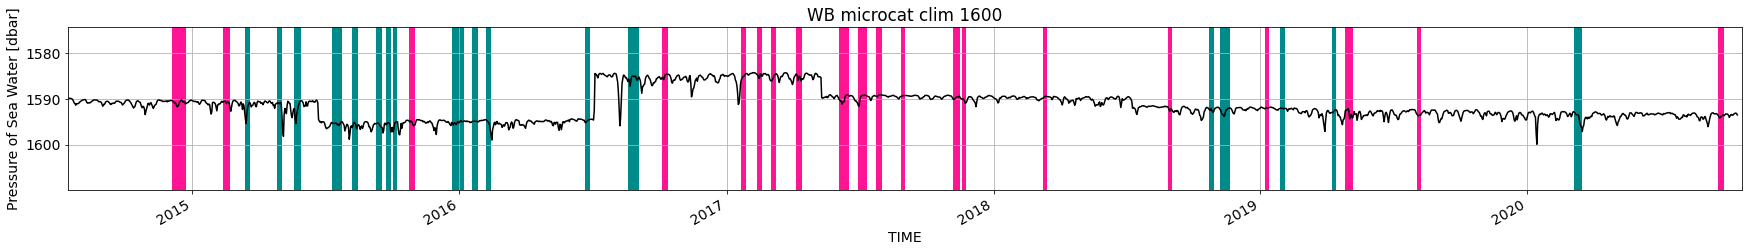

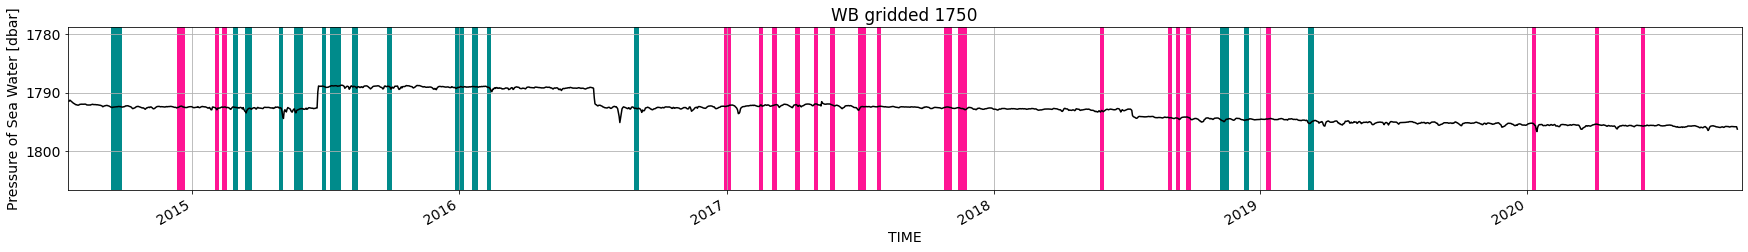

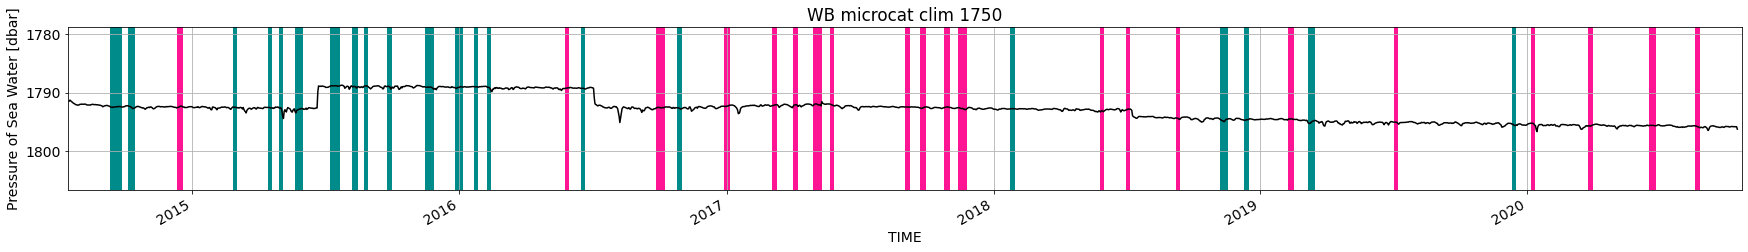

In [19]:
for i,n in enumerate(depth_WB):
    OV_stacked_events(WB_grid, n)
    ds_wb.pres.sel(DEPTH=n).plot.line(x='TIME', color='k')
    plt.ylim(ds_wb.pres.sel(DEPTH=n).max()+10, ds_wb.pres.sel(DEPTH=n).min()-10)
    plt.title(f'WB gridded {n}')
    ax = plt.axes() 
    #ax.set_facecolor("#F0FFFF") 
    #plt.savefig(f'figures/Compare_WB/WB_{n}_grid', dpi = 300)
 
    OV_stacked_events(WB_mcat, n)
    ds_wb.pres.sel(DEPTH=n).plot.line(x='TIME', color='k')
    plt.ylim(ds_wb.pres.sel(DEPTH=n).max()+10, ds_wb.pres.sel(DEPTH=n).min()-10)
    plt.title(f'WB microcat clim {n}')
    #plt.savefig(f'figures/Compare_WB/WB_{n}_mcat', dpi = 300)